# De Canaria - Regression Study

Berke Kaan Ülgen

b.kaanulgen@gmail.com

Due 27/12/2022

## Preparations

Importing necessary libraries

In [101]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from lightgbm import LGBMRegressor

Setting the seed as 1 and getting the path of the notebook file to be used later on

In [3]:
np.random.seed(1)
path = 'https://raw.githubusercontent.com/bkaanulgen/DeCanaria/main/{}.csv'

## Processing the Data

Importing the training and test data sets

In [4]:
# Importing the training data sets
df_x = pd.read_csv(path.format('X_train'))
df_y = pd.read_csv(path.format('y_train'))

# Importing the test data set
df_test = pd.read_csv(path.format('X_test'))

# Combining all of the training/test data sets in a single dataframe
df_train_all = pd.merge(df_x, df_y, on = 'key')

# Creating a separate dataframe consisting of keys
df_key = df_test['key']

Preliminary tests indicate that without using any variable of the census and market data sets as features, the model yields very low R<sup>2</sup> values. Hence, these data sets will be integrated into the training data set based on the hashed student geoid value.

Importing the census and market data sets and integrating them into the training data set


In [5]:
# Importing the data sets
df_gray = pd.read_csv(path.format('2022%2001%2028%20V2%20Gray%20Data'))
df_census = pd.read_csv(path.format('2022%2001%2028%20Census%20Data%20by%20Geoid'))

# Adding the market data to the training/test data sets based on the 'student_geoid_hashed' value
df_gray.rename(columns = {'geoid_hashed': 'student_geoid_hashed'}, inplace = True)
df_train_all = pd.merge(df_train_all, df_gray, on='student_geoid_hashed', how = 'left')
df_test = pd.merge(df_test, df_gray, on='student_geoid_hashed', how = 'left')

# Adding the census data to the training/test data sets based on the 'student_geoid_hashed' value
df_census.rename(columns = {'geoid_hashed': 'student_geoid_hashed'}, inplace = True)
df_train_all = pd.merge(df_train_all, df_census, on='student_geoid_hashed', how = 'left')
df_test = pd.merge(df_test, df_census, on='student_geoid_hashed', how = 'left')

Dropping unnecessary columns and preparing X_train and Y_train sets 

In [6]:
# Extracting the list of unique states
s1 = df_train_all['student_state'].unique()
s2 = df_train_all['nearest_campus_state'].unique()
s3 = df_test['student_state'].unique()
s4 = df_test['nearest_campus_state'].unique()

# Pairing states with indices
state_list = np.sort(np.unique(np.concatenate((s1, s2, s3, s4))))
state_dict = dict(zip(state_list, range(len(state_list))))

# Converting the states in the data sets into indices
df_train_all = df_train_all.replace({'student_state': state_dict, 'nearest_campus_state': state_dict})
df_test = df_test.replace({'student_state': state_dict, 'nearest_campus_state': state_dict})

# Converting indices in the form of integers into categorical type
df_train_all['student_state'] = df_train_all['student_state'].astype('category')
df_train_all['nearest_campus_state'] = df_train_all['nearest_campus_state'].astype('category')
df_train_all['nearest_campus_id'] = df_train_all['nearest_campus_id'].astype('category')
df_test['student_state'] = df_test['student_state'].astype('category')
df_test['nearest_campus_state'] = df_test['nearest_campus_state'].astype('category')
df_test['nearest_campus_id'] = df_test['nearest_campus_id'].astype('category')

# Renaming columns
df_train_all = df_train_all.rename(columns = {'student_state': 'student_state_id', 'nearest_campus_state': 'nearest_campus_state_id'})
df_test = df_test.rename(columns = {'student_state': 'student_state_id', 'nearest_campus_state': 'nearest_campus_state_id'})

# Dropping unnecessary columns
drop_indices = ['key', 'student_geoid_hashed', 'nearest_campus_hashed_geoid']
df_test = df_test.drop(drop_indices, axis = 1)
drop_indices += ['starts']
df_train = df_train_all.drop(drop_indices, axis = 1)

# Forming X_train and Y_train sets
X_train = np.asarray(df_train)
Y_train = np.asarray(df_train_all['starts'])

# Allocating the 20% of the entire training set to be used as the test set
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 1)

In [7]:
# Glancing over the entire training set
print(df_train)

     student_state_id nearest_campus_id nearest_campus_state_id  \
0                  14                 5                      17   
1                   8                16                       8   
2                  16                14                      14   
3                  16                18                      16   
4                   1                30                       1   
...               ...               ...                     ...   
5585               12                15                      12   
5586               22                15                      12   
5587                1                30                       1   
5588               14                 2                      14   
5589                1                30                       1   

      nearest_campus_distance   DADI  DACI   DAGI    DAEI  Inquiries   Google  \
0                    35.30720  11.15  1.95  28.50   57.09        1.0  10.1970   
1                    11.12110    

## Building the Initial Model

Preliminary works show that LGBM Regressor yields the highest adjusted R<sup>2</sup> and R<sup>2</sup> values, thus it will be used in the rest of this study

Building and fitting a LGBM Regressor model for the training set

In [8]:
# Building and fiting a regression model
reg = LGBMRegressor()
reg.fit(X_train, Y_train)

# Predicting target values using the set
Y_predict = reg.predict(X_test)

Defining a function that calculates and returns R<sup>2</sup> and adjusted R<sup>2</sup> values of a given model

In [9]:
def get_scores(reg, X_test, Y_test, print_results = True):
    # Calculating the R2 value
    r2 = reg.score(X_test, Y_test)
    n = X_test.shape[0]
    p = X_test.shape[1]

    # Calculating the adjusted R2 value
    adjusted_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
    if print_results:
        print(f'R2: {r2:.4f}, Adjusted R2: {adjusted_r2:.4f}')

    # Returning the R2 and adjusted R2 values
    return r2, adjusted_r2

Outputting the model scores

In [10]:
r2, adjusted_r2 = get_scores(reg, X_test, Y_test)

R2: 0.3008, Adjusted R2: -0.8079


R<sup>2</sup> value, <i>i.e., the coefficient of determination</i>, indicates how much of the variance in the data set can be explained through the model. The higher the R<sup>2</sup> value is, the model fits the better to the data set. An R<sup>2</sup> value of 0.30 indicates a relatively weak model, which may be improved through parameter calibration.

Adjusted R<sup>2</sup> value is adjusted for the number of features (<i>i.e., independent variables</i>) in the model. An adjusted R<sup>2</sup> value of -0.81 indicates that many features  that don't contribute to the model are used in the model. It can be fixed by removing unnecessary features.

Defining a function that plots the predicted and actual target values

In [92]:
def plot_model(Y_test, Y_predict, r2, adjusted_r2, step_size = 0.5):
    Y_error = Y_predict - Y_test
    Y_mean = np.mean(Y_error)
    Y_std = np.std(Y_error)
    #X_range = range(np.round(Y_mean - Y_std * 3, 2) - step_size, Y_mean + Y_std * 3 + step_size, step_size)
    #X_range = range(int(Y_mean - Y_std * 3) - 1, int(Y_mean + Y_std * 3) + 1, step_size)
    #X_range = range(int(min(Y_error)) - 1, int(max(Y_error)) + 1)
    X_range = np.arange(int(Y_mean - Y_std * 3) - 1, int(Y_mean + Y_std * 3) + 1, step_size)
    _, _, bars = plt.hist(Y_error, bins = X_range, edgecolor = 'black')
    #_, _, bars = plt.hist(Y_error[abs(Y_error - Y_mean) <= Y_std], bins = X_range, color = 'cyan', edgecolor = 'black')
    #_, _, bars = plt.hist(Y_error[(abs(Y_error - Y_mean) > Y_std) & (abs(Y_error - Y_mean) <= 2 * Y_std)], bins = X_range, color = 'blue', edgecolor = 'black')
    #_, _, bars = plt.hist(Y_error[(abs(Y_error - Y_mean) > 2 * Y_std) & (abs(Y_error - Y_mean) <= 3 * Y_std)], bins = X_range, color = 'green', edgecolor = 'black')
    plt.bar_label(bars)
    plt.title(f'LGBM Regressor, R2 = {r2:.2f}, Adj.R2 = {adjusted_r2:.2f}')
    plt.ylabel('Count')
    plt.xlabel('Prediction - Observation')
    plt.xticks(X_range, rotation = 45)
    plt.show()

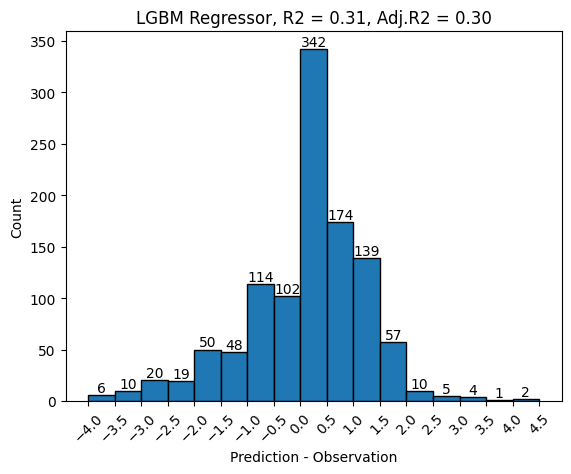

In [93]:
# Plotting the model
plot_model(Y_test, Y_predict, r2, adjusted_r2)

## Feature Selection

Calculating importance values of the features used in the model

In [33]:
# Getting the importance values of the model features
importances = reg.feature_importances_

# Using the importance values of the model features in a new data set
df_importances = pd.DataFrame({'feature': df_train.columns.values, 'importance': importances}).sort_values('importance', ascending = False).reset_index(drop = True)

In [34]:
# Glancing over the importance values
print(df_importances)

                     feature  importance
0                  Inquiries          77
1    nearest_campus_distance          44
2                       DACI          37
3                       DADI          27
4                 DIMCYLRENT          26
..                       ...         ...
680                 HMVCYDWL           0
681                 HMVCYIRE           0
682                HMVCYLIFE           0
683               HMVCYLNCRE           0
684                 WRHCYDBT           0

[685 rows x 2 columns]


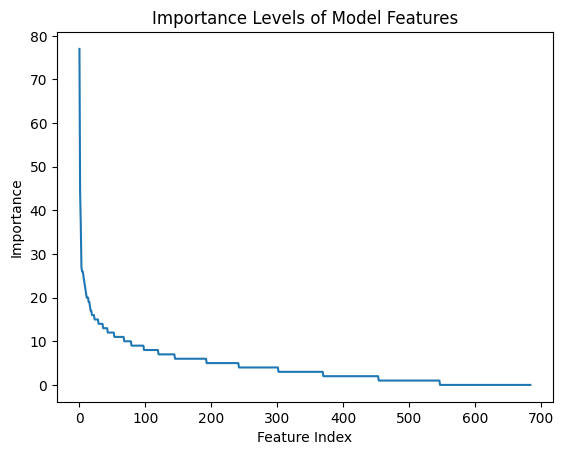

In [35]:
# Plotting the importance values of model features
plt.plot(df_importances['importance'])
plt.title('Importance Levels of Model Features')
plt.ylabel('Importance')
plt.xlabel('Feature Index')
plt.show()

Defining a function that filters out the features that have a lower importance value than the specified limit, and then building and fitting a regression model with the remaining features and returning scores

In [36]:
def remove_features(importance_limit, print_results = True):
    # Removing the features that have a lower importance value than the limit
    drop_indices_new = drop_indices + list(df_importances[df_importances.importance < importance_limit].feature)
    df_train_new = df_train_all.drop(drop_indices_new, axis = 1)

    # Reconstructing and splitting the training data set
    X_train_new = np.asarray(df_train_new)
    Y_train_new = np.asarray(df_train_all['starts'])
    X_train_new, X_test_new, Y_train_new, Y_test_new = train_test_split(X_train_new, Y_train_new, test_size = 0.2, random_state = 1)

    # Building and fitting a new regression model
    reg_new = LGBMRegressor()
    reg_new.fit(X_train_new, Y_train_new)

    # Getting scores for the new regression model and return them
    return get_scores(reg_new, X_test_new, Y_test_new, print_results)

Iterating for increasing importance limits (until the maximum importance level) and acquiring the R<sup>2</sup> scores of regression models with features that have a higher importance than the limit

In [37]:
# Empty lists
importance_levels = []
r2_values = []
adjusted_r2_values = []

# If set to true, scores will be printed for each iteration
print_results = False

for importance_limit in range(max(importances)):
    r2_new, adjusted_r2_new = remove_features(importance_limit, print_results)

    # Adding the importance and the scores to the empty lists
    importance_levels.append(importance_limit)
    r2_values.append(r2_new)
    adjusted_r2_values.append(adjusted_r2_new)

Plotting the R<sup>2</sup> and adjusted R<sup>2</sup> values examine how they are affected by the limit importance level

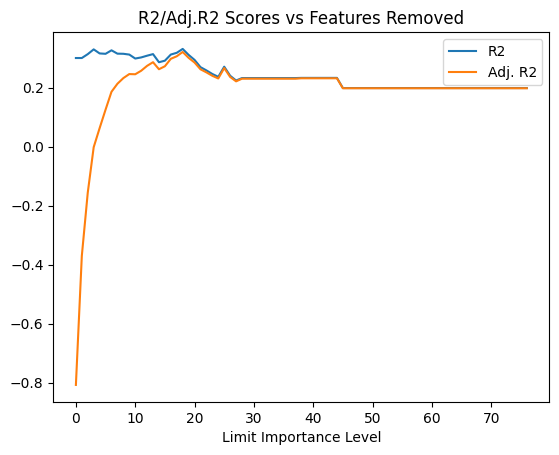

In [38]:
plt.plot(r2_values)
plt.plot(adjusted_r2_values)
plt.legend(['R2', 'Adj. R2'])
plt.title('R2/Adj.R2 Scores vs Features Removed')
plt.xlabel('Limit Importance Level')
plt.show()

Observing the plot, it can be stated that the limit importance level can be chosen as 19 for the optimum R<sup>2</sup> and adjusted R<sup>2</sup> values.

Building and fitting a new model with features that have an importance level of larger than or equal to 19 (according to the base model)

In [39]:
# Filtering out the features with an importance level of less than 19
importance_limit = 19
drop_indices_new = list(df_importances[df_importances.importance < importance_limit].feature)
df_test = df_test.drop(drop_indices_new, axis = 1)
drop_indices_new += drop_indices
df_train = df_train_all.drop(drop_indices_new, axis = 1)

# Reconstructing and splitting the training data set
X_train = np.asarray(df_train)
Y_train = np.asarray(df_train_all['starts'])
X_train, X_test, Y_train, Y_test = train_test_split( X_train, Y_train, test_size=0.2, random_state=1)

# Building and fitting a new regression model
reg = LGBMRegressor()
reg.fit(X_train, Y_train)
Y_predict = reg.predict(X_test)

In [97]:
# Getting the R2 and adjusted R2 values of the new model
r2, adjusted_r2 = get_scores(reg, X_test, Y_test)

R2: 0.3114, Adjusted R2: 0.3014


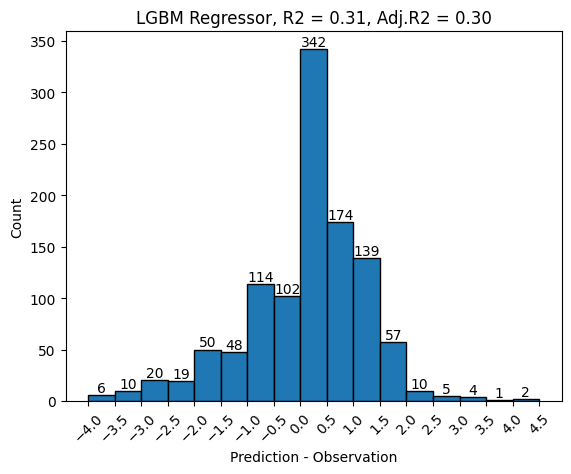

In [100]:
# Plotting the new model
plot_model(Y_test, Y_predict, r2, adjusted_r2)

In [42]:
# Glancing over the entire training data set
print(df_train)

     nearest_campus_id  nearest_campus_distance   DADI  DACI  Inquiries  \
0                    5                 35.30720  11.15  1.95        1.0   
1                   16                 11.12110    NaN   NaN        NaN   
2                   14                 36.67160  37.13  3.55        2.0   
3                   18                 22.60040  39.15  3.40       13.0   
4                   30                  2.71135   7.39  3.38        2.0   
...                ...                      ...    ...   ...        ...   
5585                15                 22.60700  12.59  0.83        6.0   
5586                15                 22.60700   5.82  0.57        1.0   
5587                30                  2.71135   6.90  2.79       13.0   
5588                 2                 14.11500  34.21  3.21        1.0   
5589                30                  2.71135   7.32  2.92        3.0   

      BLS Job Openings  AGRCYBLACK  DIMCYEXPH  DIMCYGOVTW  DIMCYHLTEM  \
0               1.6616    

In [43]:
# Outputting the features used in the model
print(df_train.columns.values)

['nearest_campus_id' 'nearest_campus_distance' 'DADI' 'DACI' 'Inquiries'
 'BLS Job Openings' 'AGRCYBLACK' 'DIMCYEXPH' 'DIMCYGOVTW' 'DIMCYHLTEM'
 'DIMCYLRENT' 'DIMCYMCHOU' 'DIMCYMOBH' 'DIMCYRETEM' 'DIMCYRNTF'
 'FINCY2530']


## Hyperparameter Calibration

Hyperparameters are calibrated manually with an iterative approach.

Calibrating and visualizing the parameter 'num_leaves'

In [44]:
# Empty lists
parameters = []
r2_values = []
adjusted_r2_values = []

# If set to true, scores will be printed for each iteration
show_iterations = True

for param in range(0, 100, 1):
    try:
        # Starting with the first parameter, num_leaves
        params = {'num_leaves': param}

        # Building and fitting the model, then getting the scores
        reg_new = LGBMRegressor(**params)
        reg_new.fit(X_train, Y_train)

        r2_new, adjusted_r2_new = get_scores(reg_new, X_test, Y_test, False)

        if show_iterations:
            print(f'R2: {r2_new:.4f} Adj.R: {adjusted_r2_new:.4f} for parameters {params}')

        # Adding the parameter and the scores to the empty lists
        parameters.append(param)
        r2_values.append(r2_new)
        adjusted_r2_values.append(adjusted_r2_new)

    except:
        pass

R2: 0.2380 Adj.R: 0.2269 for parameters {'num_leaves': 2}
R2: 0.2846 Adj.R: 0.2742 for parameters {'num_leaves': 3}
R2: 0.3150 Adj.R: 0.3051 for parameters {'num_leaves': 4}
R2: 0.3168 Adj.R: 0.3069 for parameters {'num_leaves': 5}
R2: 0.3245 Adj.R: 0.3147 for parameters {'num_leaves': 6}
R2: 0.3278 Adj.R: 0.3181 for parameters {'num_leaves': 7}
R2: 0.3280 Adj.R: 0.3183 for parameters {'num_leaves': 8}
R2: 0.3325 Adj.R: 0.3228 for parameters {'num_leaves': 9}
R2: 0.3288 Adj.R: 0.3190 for parameters {'num_leaves': 10}
R2: 0.3256 Adj.R: 0.3158 for parameters {'num_leaves': 11}
R2: 0.3290 Adj.R: 0.3193 for parameters {'num_leaves': 12}
R2: 0.3261 Adj.R: 0.3163 for parameters {'num_leaves': 13}
R2: 0.3167 Adj.R: 0.3068 for parameters {'num_leaves': 14}
R2: 0.3197 Adj.R: 0.3098 for parameters {'num_leaves': 15}
R2: 0.3320 Adj.R: 0.3223 for parameters {'num_leaves': 16}
R2: 0.3305 Adj.R: 0.3208 for parameters {'num_leaves': 17}
R2: 0.3261 Adj.R: 0.3163 for parameters {'num_leaves': 18}
R2: 0

In [45]:
# Outputting maximum values of R2 and adjusted R2 for varying num_leaves
# For the maximum value of R2
r2_1 = max(r2_values)
index_1 = r2_values.index(r2_1)
param_1 = parameters[index_1]
r2_adj_1 = adjusted_r2_values[index_1]

# For the maximum value of adjusted R2
r2_adj_2 = max(adjusted_r2_values)
index_2 = adjusted_r2_values.index(r2_adj_2)
param_2 = parameters[index_2]
r2_2 = r2_values[index_2]

#
print(f'For \'num_leaves\': {index_1}, R2: {r2_1:.4f} AdjR2:{r2_adj_1:.4f} (Max R2)')
print(f'For \'num_leaves\': {index_2}, R2: {r2_2:.4f} AdjR2:{r2_adj_2:.4f} (Max AdjR2)')

For 'num_leaves': 19, R2: 0.3326 AdjR2:0.3229 (Max R2)
For 'num_leaves': 19, R2: 0.3326 AdjR2:0.3229 (Max AdjR2)


Setting 'num_leaves' to be 19 gives the maximum R2 and adjusted R2.

Plotting R2 & adjusted R2 values vs. num_leaves 

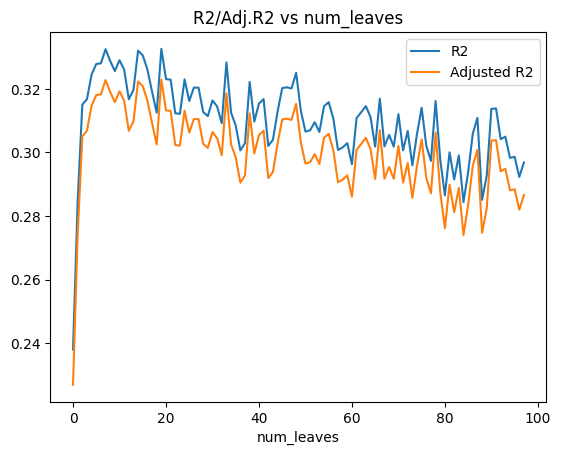

In [46]:
plt.plot(r2_values)
plt.plot(adjusted_r2_values)
plt.legend(['R2', 'Adjusted R2'])
plt.title('R2/Adj.R2 vs num_leaves')
plt.xlabel('num_leaves')
plt.show()

The process is repeated for all arguments of LGBMRegressor() and optimum parameters are obtained.

Building and fitting a calibrated model with the calibrated hyperparameters

In [47]:
# Optimum model hyperparameters obtained through manual calibration
params = {
        'num_leaves': 19,
        'max_depth': 8,
        'learning_rate': 0.14,
        'n_estimators': 25,
        'min_split_gain': 4.54,
        'min_child_samples': 12,
        'colsample_bytree': 0.75,
        'reg_lambda': 2.44
        }

R2: 0.3352, Adjusted R2: 0.3256


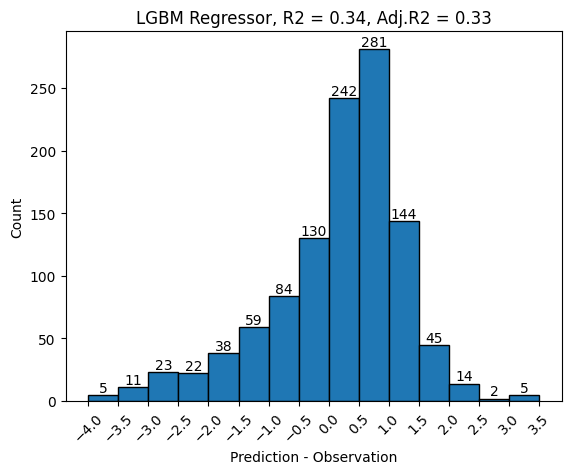

In [95]:
reg_calibrated = LGBMRegressor(**params)
reg_calibrated.fit(X_train, Y_train)

Y_predict_calibrated = reg_calibrated.predict(X_test)

r2_calibrated, adjusted_r2_calibrated = get_scores(reg_calibrated, X_test, Y_test)

plot_model(Y_test, Y_predict_calibrated, r2_calibrated, adjusted_r2_calibrated)

## Making Predictions for the Test Data Set

Building the final model using the entire training data set and make predictions for X_test values

In [49]:
# Adjusting data sets
X_train_final = np.asarray(df_train)
Y_train_final = np.asarray(df_train_all['starts'])
X_test_final = np.asarray(df_test)

# Building and fitting the model
reg_final = LGBMRegressor(**params)
reg_final.fit(X_train_final, Y_train_final)

# Making predictions
Y_predict_final = reg_final.predict(X_test_final)

Creating a dataframe for the predictions

In [50]:
df_predictions = pd.DataFrame()
df_predictions['key'] = df_key
df_predictions['starts'] = Y_predict_final
print(df_predictions)

      key    starts
0    6188  1.233524
1     273  2.060737
2     942  1.387039
3    5067  1.556532
4     770  2.472524
..    ...       ...
617  1610  1.514348
618  5367  2.133032
619  1906  1.514348
620  4835  1.336054
621  1783  1.514348

[622 rows x 2 columns]


Outputting the dataframe as a .csv file

In [51]:
#df_predictions.to_csv(path + 'y_predict.csv', index = False)

HTTPError: ignored